In [1]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../sdpm_py_util')
import ocn_functions as ocnfuns
import plotting_functions as pltfuns
import glob
from get_PFM_info import get_PFM_info
from datetime import datetime, timedelta
from netCDF4 import num2date, date2num, date2index
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import grid_functions as grdfuns


/home/mspydell/models/PFM_root/PFM/driver/../sdpm_py_util/ocn_functions.py:28: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater


In [2]:

# Use the glob module to get a list of all files in the current directory
PFM=get_PFM_info()
fn = '/scratch/PFM_Simulations/LV1_Forecast/His/Worked/LV1_ocean_his.nc'

his_ds = netCDF4.Dataset(fn)
#print(his_ds.variables)

swell


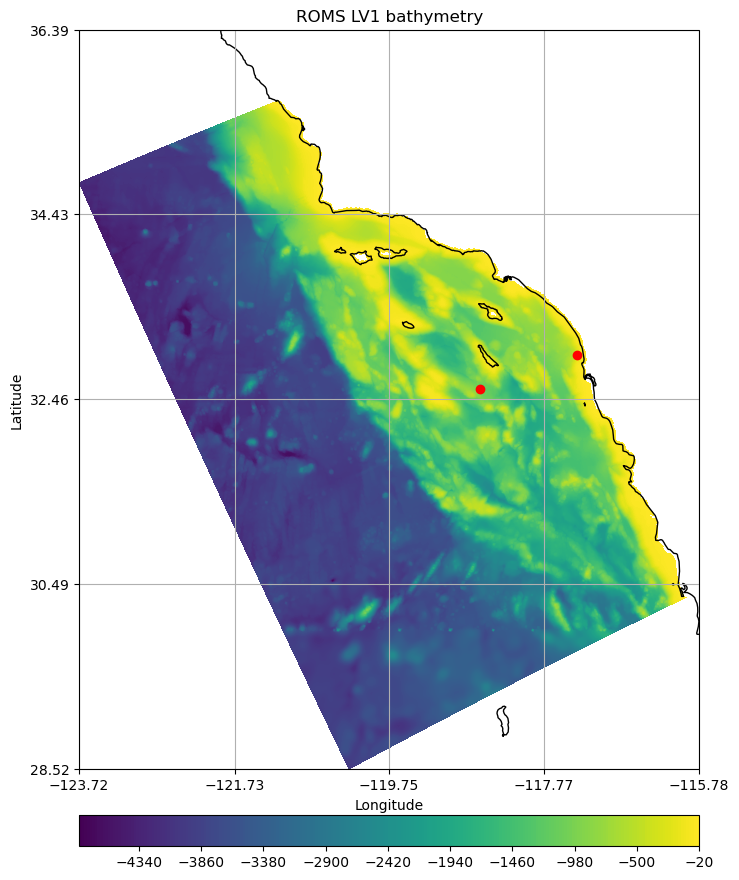

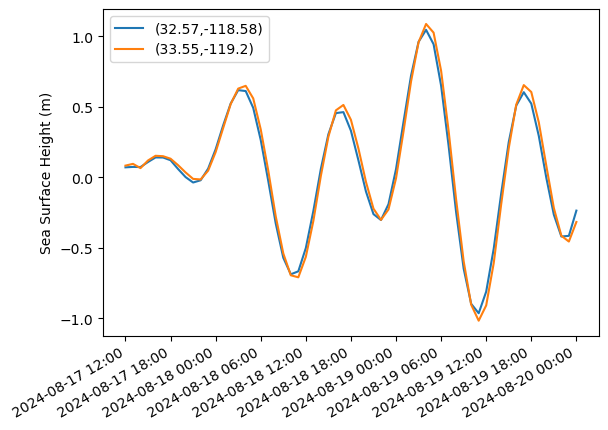

In [50]:
def plot_ssh_his_tseries(fn,Iy,Ix):
    his_ds = netCDF4.Dataset(fn)
    times = his_ds.variables['ocean_time']
    times2 = num2date(times[:], times.units)
    times2 = np.array([datetime(year=date.year, month=date.month, day=date.day, 
                              hour=date.hour, minute=date.minute, second=date.second) for date in times2])
    fig, ax = plt.subplots()
    ln = his_ds.variables['lon_rho'][:]
    lt = his_ds.variables['lat_rho'][:]
    txt_lg = []
    for a in range(len(Ix)):
        yy = his_ds.variables['zeta'][:,Iy[a],Ix[a]]
        ax.plot(times2,yy)
        ln3=ln[Iy[a],Ix[a]]
        lt3=lt[Iy[a],Ix[a]]
        ln3 = .01 * round(ln3*100)
        lt3 = .01 * round(lt3*100)
        txt = '(' + str(lt3) + ',' + str(ln3) + ')'
        txt_lg.append(txt)
            
    plt.legend(txt_lg, loc="upper left")    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.gcf().autofmt_xdate()
    ax.set_ylabel('Sea Surface Height (m)')

def plot_roms_LV1_bathy_and_locs(fn,Ix,Iy):
    his_ds = netCDF4.Dataset(fn)
    fig, ax = plt.subplots(figsize=(8, 12), subplot_kw={'projection': ccrs.PlateCarree()})
    lt = his_ds.variables['lat_rho'][:]
    ln = his_ds.variables['lon_rho'][:]
    hb = his_ds.variables['h'][:]
    plevs = np.arange(-4800, 0, 20)
    cmap = plt.get_cmap('viridis')
    cset = ax.contourf(ln, lt, -hb, plevs, cmap=cmap, transform=ccrs.PlateCarree())
    plt.set_cmap(cmap)
    cbar = fig.colorbar(cset, ax=ax, orientation='horizontal', pad = 0.05)
    for a in range(len(Ix)):
        ax.plot(ln[Iy[a],Ix[a]],lt[Iy[a],Ix[a]],'ro')

    ax.set_title('ROMS LV1 bathymetry')
    ax.add_feature(cfeature.COASTLINE)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True)
    ax.set_aspect(aspect='auto')
    ax.set_xticks(np.round(np.linspace(np.min(ln), np.max(ln), num=5), 2))
    ax.set_yticks(np.round(np.linspace(np.min(lt), np.max(lt), num=5), 2))

    plt.show()



yyyymmddhhmm='202408171200'
fn = '/scratch/PFM_Simulations/LV1_Forecast/His/Worked/LV1_ocean_his.nc'
Ix = np.array([175,240])
Iy = np.array([175,170])
fn_out1 = '/scratch/PFM_Simulations/LV1_Forecast/Plots/bathymap' + yyyymmddhhmm + '.nc'
fn_out2 = '/scratch/PFM_Simulations/LV1_Forecast/Plots/ssh_tseries' + yyyymmddhhmm + '.nc'
plot_roms_LV1_bathy_and_locs(fn,Ix,Iy,fn_out1)
plot_ssh_his_tseries(fn,Ix,Iy,fn_out2)



swell
swell
swell
swell


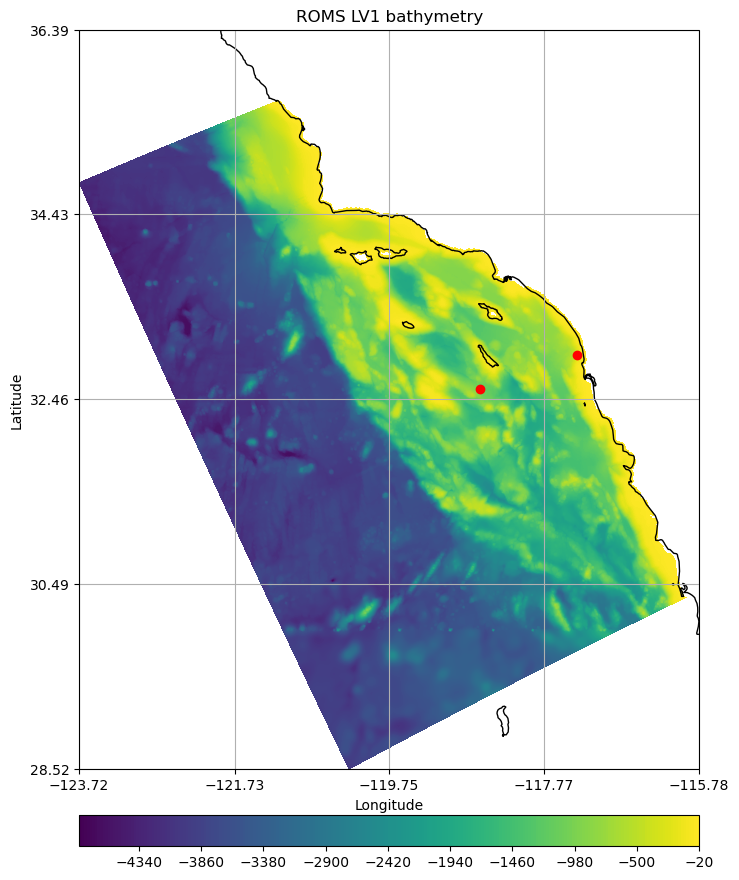

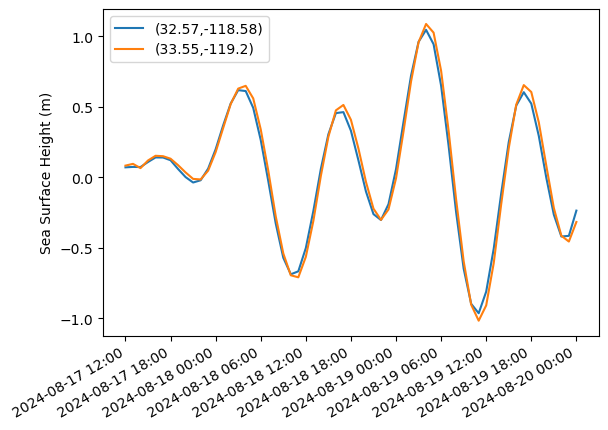

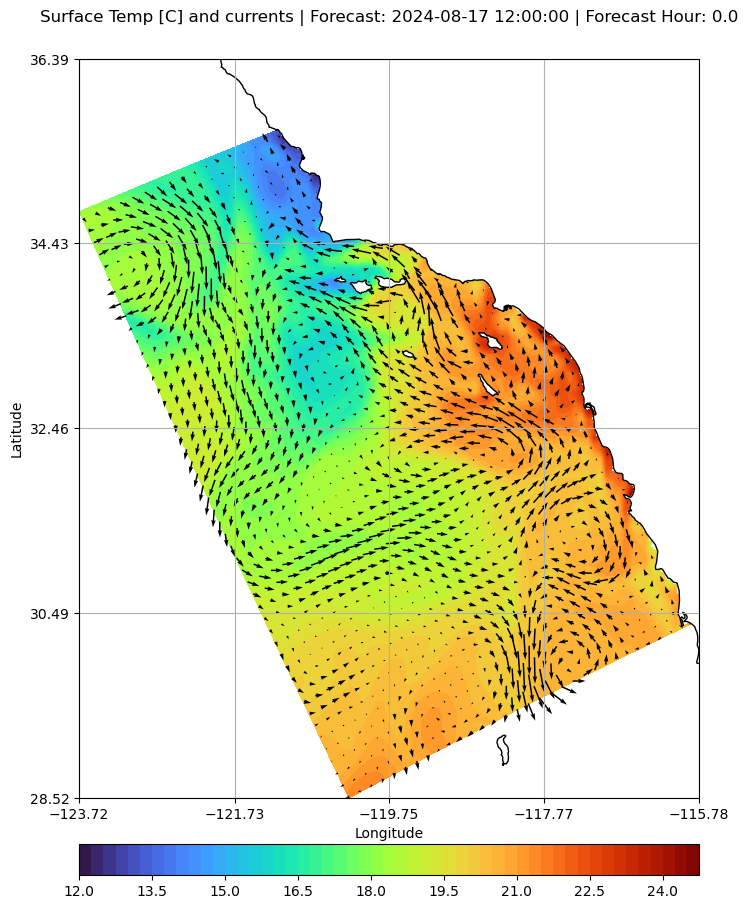

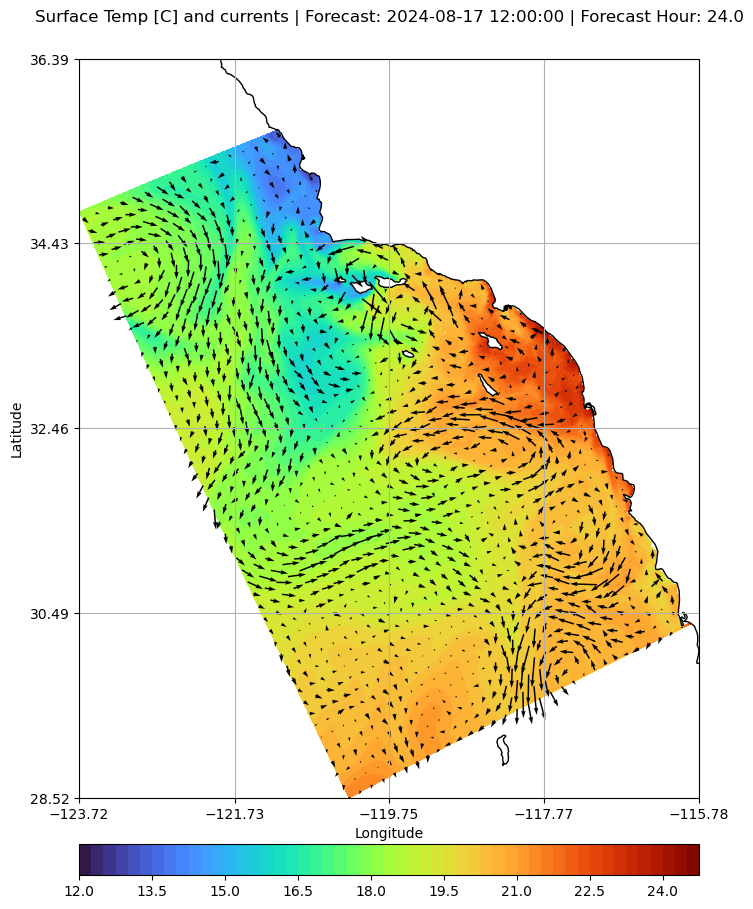

In [3]:
fn = '/scratch/PFM_Simulations/LV1_Forecast/His/Worked/LV1_ocean_his.nc'
Ix = np.array([175,240])
Iy = np.array([175,170])
It = 0
sv_fig = 1

pltfuns.plot_roms_LV1_bathy_and_locs(fn,Ix,Iy,sv_fig)
pltfuns.plot_ssh_his_tseries(fn,Ix,Iy,sv_fig)
pltfuns.plot_his_temps_wuv(fn,It,-1,sv_fig)
pltfuns.plot_his_temps_wuv(fn,It+24,-1,sv_fig)

swell


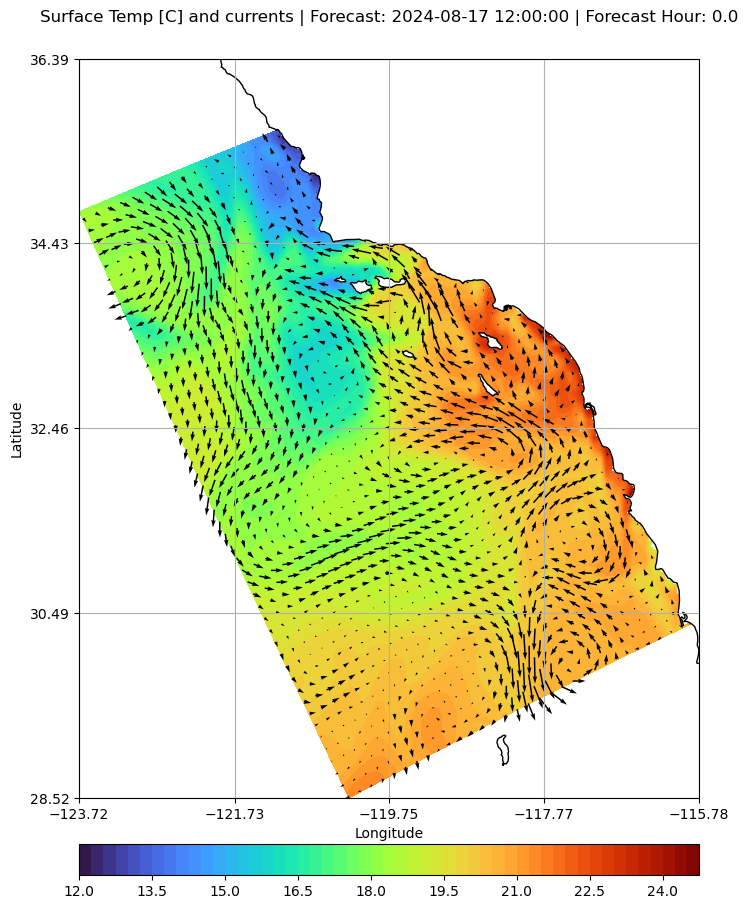

In [35]:
def plot_his_temps_wuv(fn,It,Iz):

    PFM=get_PFM_info()
    RMG = grdfuns.roms_grid_to_dict(PFM['lv1_grid_file'])

    his_ds = netCDF4.Dataset(fn)
    lt = his_ds.variables['lat_rho'][:]
    ln = his_ds.variables['lon_rho'][:]
    temp = his_ds.variables['temp'][It,Iz,:,:]

    urm = np.squeeze( his_ds.variables['u'][It,Iz,:,:] )
    vrm = np.squeeze( his_ds.variables['v'][It,Iz,:,:] )
    urm2 = np.squeeze( .5 * (urm[0:-1,:]+urm[1:,:]) ) # now on rho points, but not 0 or -1
    vrm2 = np.squeeze( .5 * (vrm[:,0:-1]+vrm[:,1:]) )
    ang = RMG['angle'] # on rho points
    ang2 = np.squeeze( .5* (ang[0:-1,0:-1] + ang[1:,1:]  ))
    u = urm2 * np.cos(ang2) - vrm2 * np.sin(ang2)
    v = vrm2 * np.cos(ang2) + urm2 * np.sin(ang2)

    #print(np.shape(u))
    #print(np.shape(v))

    fig, ax = plt.subplots(figsize=(8, 12), subplot_kw={'projection': ccrs.PlateCarree()})
    plevs = np.arange(np.floor(np.min(temp)), np.ceil(np.max(temp)), .25)
    cmap = plt.get_cmap('turbo')
    cset = ax.contourf(ln, lt, temp, plevs, cmap=cmap, transform=ccrs.PlateCarree())
    plt.set_cmap(cmap)
    cbar = fig.colorbar(cset, ax=ax, orientation='horizontal', pad = 0.05)

    ln2 = .5* (ln[0:-1,0:-1]+ln[1:,1:])
    lt2 = .5* (lt[0:-1,0:-1]+lt[1:,1:])


    ax.quiver(ln2[0::8,0::8], lt2[0::8,0::8], u[0::8,0::8], v[0::8,0::8], transform=ccrs.PlateCarree())

    times = his_ds.variables['ocean_time']
    times2 = num2date(times[:], times.units)
    times2 = np.array([datetime(year=date.year, month=date.month, day=date.day, 
                              hour=date.hour, minute=date.minute, second=date.second) for date in times2])

    start_time = times2[0]
    forecast_hours = 3*It
    annotation = f'Surface Temp [C] and currents | Forecast: {start_time.strftime("%Y-%m-%d %H:%M:%S")} | Forecast Hour: {forecast_hours:.1f}'

    ax.text(0.5, 1.05, annotation, transform=ax.transAxes, ha='center', fontsize=12)
    ax.add_feature(cfeature.COASTLINE)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True)
    ax.set_aspect(aspect='auto')
    ax.set_xticks(np.round(np.linspace(np.min(ln), np.max(ln), num=5), 2))
    ax.set_yticks(np.round(np.linspace(np.min(lt), np.max(lt), num=5), 2))



fn = '/scratch/PFM_Simulations/LV1_Forecast/His/Worked/LV1_ocean_his.nc'
plot_his_temps_wuv(fn,0,-1)